**This notebook provides an examplory analysis of Flats for Sale.**

Even though the analysis is specific, the logic can be used to other categories as well. Columns will differ.

In [604]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import sqlite3
import seaborn as sns
from scipy import stats

### Loading data from SQLite:

In [605]:
path_to_sqlite='estate_data.sqlite'
con = sqlite3.connect(path_to_sqlite)

In [606]:
print("Tables in our database:\n")
cursor = con.cursor()
# Getting all tables from sqlite_master
sql_query = """SELECT name FROM sqlite_master WHERE type='table';"""
cursor.execute(sql_query)
sqlite_tables = cursor.fetchall()
sqlite_tables = [*map(lambda table: table[0] ,sqlite_tables)]
print(sqlite_tables)
del sqlite_tables
del sql_query

Tables in our database:

['OFFERS_APARTMENTS_SALE', 'DESCRIPTION_TABLE']


In [607]:
df_description = pd.read_sql('SELECT * FROM DESCRIPTION_TABLE', con = con)

In [608]:
df_offers = pd.read_sql('SELECT * FROM OFFERS_APARTMENTS_SALE', con = con)

In [609]:
df_offers.shape, df_description.shape

((22140, 21), (22071, 35))

Note: df_offers has more rows as some offers disappeared before description download was finished.

In [610]:
# Closing the connection
con.close()

### Data types:

In [611]:
df_offers.dtypes

hash_id                 int64
price                   int64
price_czk               int64
price_czk_unit         object
price_czk_name         object
area                    int64
lat                   float64
lon                   float64
locality               object
flat_type              object
type                    int64
category                int64
is_auction              int64
exclusively_at_rk       int64
category_main           int64
category_sub            int64
category_type           int64
company_id            float64
company_name           object
date_download          object
locality_region_id      int64
dtype: object

In [612]:
df_description.dtypes

hash_id                           object
description                       object
discounted                        object
date_update                       object
building_type                     object
building_condition                object
building_location                 object
area_net                          object
area_floor                        object
price_total                       object
price_note                        object
transport                         object
area_build_up                     object
equipped                          object
electricity                       object
traffic_communication             object
barrier_free                     float64
energy_efficient_rating           object
lift                             float64
building_floor_type               object
building_floor                    object
water                             object
gas                               object
waste                             object
heating         

We must correctly convert data types of df_description.

In [613]:
# Columns which have spaces between numbers
columns_to_transform = ["price_total", "discounted"]
for col in columns_to_transform:
    # 1.
    df_description[col].replace(np.nan, "None", inplace=True)
    # 2.
    df_description[col] = df_description[col].apply(lambda x: x.replace("\xa0", ""))
    # 3.
    df_description[col].replace("None", np.nan, inplace=True)

del columns_to_transform

'energy_efficient_rating_index' has "," instead of "." which needs to be tackle before can be converted to float

In [614]:
def repl(value):
    if value != None:
        return value.replace(",", ".")

df_description["energy_efficient_rating_index"] = df_description["energy_efficient_rating_index"].apply(lambda row: repl(row))

In [615]:
# Convert to correct data types - we usually use float64 instead of int64 to keep NaN
settings = {"hash_id" : np.int64,
            "discounted" : np.float64,
            "area_net" : np.float64,
            "area_floor" : np.float64,
            "price_total" : np.float64,
            "area_build_up" : np.float64,
            "area_garden" : np.float64,
            "energy_efficient_rating_index" : np.float64,
            "lift" : object,
            "barrier_free" : object   
}

df_description = df_description.astype(settings)
del settings

In [616]:
# Checking
df_description.dtypes

hash_id                            int64
description                       object
discounted                       float64
date_update                       object
building_type                     object
building_condition                object
building_location                 object
area_net                         float64
area_floor                       float64
price_total                      float64
price_note                        object
transport                         object
area_build_up                    float64
equipped                          object
electricity                       object
traffic_communication             object
barrier_free                      object
energy_efficient_rating           object
lift                              object
building_floor_type               object
building_floor                    object
water                             object
gas                               object
waste                             object
heating         

### Joining:

We join these 2 tables as their have both 'hash_id' column.

In [617]:
df = df_description.merge(df_offers, on = "hash_id", how = "inner")

In [618]:
df.shape

(22071, 55)

In [619]:
# We do not need those anymore
del df_offers
del df_description

**Note that we are using data extracted during one day in 2023-02-05:**

In [620]:
print(df["date_download"].nunique(), "\n")
print(df["date_download"].value_counts())

1 

2023-02-05    22071
Name: date_download, dtype: int64


In [621]:
df.columns

Index(['hash_id', 'description', 'discounted', 'date_update', 'building_type',
       'building_condition', 'building_location', 'area_net', 'area_floor',
       'price_total', 'price_note', 'transport', 'area_build_up', 'equipped',
       'electricity', 'traffic_communication', 'barrier_free',
       'energy_efficient_rating', 'lift', 'building_floor_type',
       'building_floor', 'water', 'gas', 'waste', 'heating',
       'telecommunication', 'energy_efficient_rating_card', 'availability',
       'energy_efficient_rating_index', 'area_garden', 'parking', 'garage',
       'ownership', 'cellar', 'balcony', 'price', 'price_czk',
       'price_czk_unit', 'price_czk_name', 'area', 'lat', 'lon', 'locality',
       'flat_type', 'type', 'category', 'is_auction', 'exclusively_at_rk',
       'category_main', 'category_sub', 'category_type', 'company_id',
       'company_name', 'date_download', 'locality_region_id'],
      dtype='object')

### Dropping columns - 1st stage:

Price column - multiple options

In [622]:
df[df.columns[df.columns.str.contains("price")]]   # We believe, price_total column is correct so we simply drop columns gained from df_offers

price_total                                         price_note  \
0       11500000.0                                               None   
1              NaN                                     cena u makléře   
2        1780000.0                                               None   
3        3900000.0                                               None   
4        1599000.0  včetně DPH, včetně poplatků, včetně provize, v...   
...            ...                                                ...   
22066     993600.0  V případě více zájemců může RK využít pro výbě...   
22067    1999990.0                                               None   
22068    8610000.0  v ceně sklepní kóje, parkovací stání, moderní ...   
22069    5546700.0                          Včetně realitního servisu   
22070    3290000.0                                               None   

         price  price_czk price_czk_unit price_czk_name  
0      7662000    7662000                  Celková cena  
1            0          0                  Celková cena  
2      1869000    1869000                  Celková cena  
3      2598000    2598000                  Celková cena  
4      1065000    1065000                  Celková cena  
...        ...        ...            ...            ...  
22066   498000     498000                  Celková cena  
22067  1003000    1003000                  Celková cena  
22068  4319000    4319000                  Celková cena  
22069  2782000    2782000                  Celková cena  
22070  1650000    1650000                  Celková cena  

[22071 rows x 6 columns]

Area

In [623]:
df[df.columns[df.columns.str.contains("area")]] # Again, we believe "area" gained from df_offers is wrong so we drop it.

area_net  area_floor  area_build_up  area_garden  area
0         132.0         NaN            NaN          NaN    87
1          47.0        47.0            NaN          NaN    49
2          72.0        72.0            NaN          NaN    75
3          72.0        72.0            NaN          NaN    47
4          45.0         NaN            NaN          NaN    29
...         ...         ...            ...          ...   ...
22066      31.0         NaN            NaN          NaN    15
22067      40.0        37.0            NaN          NaN    20
22068     101.0        94.0            NaN          NaN    50
22069      88.0        88.0            NaN          NaN    44
22070      65.0        65.0            NaN          NaN    32

[22071 rows x 5 columns]

We also drop:
- 'building_floor_type' as it has only NaN
- 'energy_efficient_rating_card' as it has no useful information
- 'type' as it is the same as 'category_type'
- 'category' as it is the same as 'category_main'

In [624]:
# Drop columns, we do not care about 
columns_to_drop = ['price',
                   'price_czk',
                   'price_czk_name',
                   'price_czk_unit',
                   'area',
                   'building_floor_type',
                   'energy_efficient_rating_card',
                   'type',
                   'category',
                   'is_auction'
                   ]

df.drop(columns_to_drop, axis=1, inplace= True)
del columns_to_drop

### Cleaning columns:

Lists in cells cannot be saved into SQLite so we used the trick to save them as a string seperated by double space.

In [625]:
# Transform them back to lists
columns_w_mult_values = ["transport", "electricity", "telecommunication"]

def transformer(value):
    if value != None:
        return value.split("  ")

for column in columns_w_mult_values:
        df[column] = df[column].apply(lambda row: transformer(row))

In [626]:
df[columns_w_mult_values]

transport   electricity  \
0                     [Silnice, MHD, Autobus]          None   
1                                        None          None   
2               [Vlak, Silnice, MHD, Autobus]        [230V]   
3                                        None          None   
4      [Vlak, Dálnice, Silnice, MHD, Autobus]        [230V]   
...                                       ...           ...   
22066                 [Silnice, MHD, Autobus]  [120V, 230V]   
22067                                    None        [230V]   
22068       [Vlak, Dálnice, Silnice, Autobus]        [230V]   
22069                [Vlak, Silnice, Autobus]        [230V]   
22070  [Vlak, Dálnice, Silnice, MHD, Autobus]          None   

                                     telecommunication  
0                                                 None  
1                                                 None  
2      [Internet, Kabelová televize, Kabelové rozvody]  
3                                                 None  
4                                            [Ostatní]  
...                                                ...  
22066                              [Kabelová televize]  
22067                                             None  
22068                    [Internet, Kabelová televize]  
22069            [Telefon, Internet, Kabelové rozvody]  
22070                                             None  

[22071 rows x 3 columns]

In [627]:
possible_values = {"transport" : ["Vlak", "Dálnice", "Silnice", "MHD", "Autobus"],
                   "electricity" : ["230V", "400V", "120V"],
                   "telecommunication" : ["Internet", "Telefon", "Kabelové rozvody", "Satelit", "Kabelová televize"] # "Ostatní"
                    }

def transformer(value):
    if value != None:
        if y in value:
            return True
        else:
            return False

for i in possible_values:
    for y in possible_values[i]:
        df[y] = df[i].apply(lambda row: transformer(row))

del columns_w_mult_values
del possible_values

### Dropping columns - 2nd stage:

In [628]:
# Drop columns, we do not care about 
columns_to_drop = ['transport',
                   'electricity',
                   'telecommunication'
                   ]

df.drop(columns_to_drop, axis=1, inplace= True)
del columns_to_drop

Next we transform columns:
- 'barrier_free', 'lift' - if 1: assign true; if 0: assign false
- 'equipped'- if ano: assign true; if ne: assign false
- 'balcony', 'cellar' - if 1: assign true
- 'garage', 'parking' - if not NaN: assign true
- 'locality_region_id' - assign name of the region
- 'energy_efficient_rating' - assign number which indicates the rating
- 'building_floor' -

Note: if value in columns 'balcony' and 'cellar' is > 1 then it corresponds to square meters.

In [629]:
columns = ["lift", "barrier_free"]
for col in columns:
    df[col].replace(1, "true", inplace = True)
    df[col].replace(0, "false", inplace = True)
del columns

In [630]:
# 'equipped'
df['equipped'].replace("ano", "true", inplace = True)
df['equipped'].replace("ne", "false", inplace = True)

In [631]:
df["balcony"].replace("1", "true", inplace = True)
df["cellar"].replace("1", "true", inplace = True)

In [632]:
# "garage", "parking"
def transformer(value):
    if value != None:
        return True
    
df["garage"] = df["garage"].apply(lambda row: transformer(row))
df["parking"] = df["parking"].apply(lambda row: transformer(row))     

In [633]:
# "locality_region_id"

mapping = {1:"Jihočeský kraj",
           2:"Plzeňský kraj",
           3:"Karlovarský kraj",
           4:"Ústecký kraj",
           5:"Liberecký kraj",
           6:"Královéhradecký kraj",
           7:"Pardubický kraj",
           8:"Olomoucký kraj",
           9:"Zlínský kraj",
           10:"Praha",
           11:"Středočeský kraj",
           12:"Moravskoslezský kraj",
           13:"Vysočina kraj",
           14:"Jihomoravský kraj"
           }

df["locality_region_id"].replace(mapping, inplace = True)
del mapping

In [634]:
# We rename the column
df.rename(columns={'locality_region_id': 'region'}, inplace = True)

In [635]:
# 'energy_efficient_rating'
def transformer(value):
    if value != None:
        return value.split()[1]
df['energy_efficient_rating'] = df['energy_efficient_rating'].apply(lambda row: transformer(row))
df['energy_efficient_rating'].value_counts()

G    9188
B    4272
C    3735
D    1456
E     441
A     282
F     155
Name: energy_efficient_rating, dtype: int64

In [636]:
# "building_floor" --> This is very manual approach --> there is a space for improvement.
def transformer(value):
    if (value != None) & (len(value.split()[0]) <= 3):
        if len(value.split()[0]) == 2:
            return value.split()[0][0]
        if len(value.split()[0]) == 3:
            return value.split()[0][:2]

df["floor"] = df["building_floor"].apply(lambda row: transformer(row))

In [637]:
df["floor"].value_counts().sort_values(ascending = False)

2     5146
1     4703
3     4092
4     3006
5     1758
6     1153
7      801
8      551
9      232
10     152
11     132
12      96
-1      57
13      54
14      22
15       9
-2       5
17       1
20       1
24       1
18       1
19       1
82       1
16       1
28       1
Name: floor, dtype: int64

In [638]:
df["floor"].dtype

dtype('O')

We keep column 'building_floor' as there is additional info.

In [639]:
# Our final 'clean' df
df

hash_id                                        description  \
0          261724  Nabizíme Vám na prodej exkluzivní mezonetový b...   
1          571212  Nabízíme moderní byt 2+kk v klidové zóně se sn...   
2          726604  Představujeme k prodeji bytovou jednotku o vel...   
3         1168460  Nabízíme k prodeji  investiční nabídku v těsné...   
4         1427276  Nabízíme k prodeji podkrovní byt v osobním vla...   
...           ...                                                ...   
22066  4289643596  Nabízíme k prodeji, družstevní byt 1+kk, 31m2 ...   
22067  4291221068  Exkluzivně Vám nabízím byt 1+1 s balkonem v os...   
22068  4291942492  Nabízíme Vám byt 3+kk, podlahová plocha 94,2 m...   
22069  4293637196  Exkluzivně nabízíme moderní nadstandardní byt ...   
22070  4294759500  Upřednostňujete bydlení na malém městě s dobro...   

       discounted date_update building_type building_condition  \
0             NaN  05.01.2023       Smíšená        Velmi dobrý   
1             NaN  12.01.2023       Smíšená     V rekonstrukci   
2             NaN  13.01.2023      Panelová        Velmi dobrý   
3             NaN  20.01.2023       Cihlová              Dobrý   
4             NaN  17.01.2023       Cihlová              Dobrý   
...           ...         ...           ...                ...   
22066         NaN  03.02.2023      Panelová              Dobrý   
22067         NaN  30.01.2023      Panelová        Velmi dobrý   
22068         NaN  22.11.2022       Cihlová        Ve výstavbě   
22069         NaN  31.01.2023       Cihlová         Novostavba   
22070         NaN  01.02.2023      Panelová              Dobrý   

      building_location  area_net  area_floor  price_total  ... Autobus  230V  \
0                  None     132.0         NaN   11500000.0  ...    True  None   
1      Klidná část obce      47.0        47.0          NaN  ...    None  None   
2                  None      72.0        72.0    1780000.0  ...    True  True   
3          Centrum obce      72.0        72.0    3900000.0  ...    None  None   
4          Centrum obce      45.0         NaN    1599000.0  ...    True  True   
...                 ...       ...         ...          ...  ...     ...   ...   
22066  Klidná část obce      31.0         NaN     993600.0  ...    True  True   
22067      Centrum obce      40.0        37.0    1999990.0  ...    None  True   
22068  Klidná část obce     101.0        94.0    8610000.0  ...    True  True   
22069      Centrum obce      88.0        88.0    5546700.0  ...    True  True   
22070  Klidná část obce      65.0        65.0    3290000.0  ...    True  None   

        400V   120V Internet Telefon Kabelové rozvody Satelit  \
0       None   None     None    None             None    None   
1       None   None     None    None             None    None   
2      False  False     True   False             True   False   
3       None   None     None    None             None    None   
4      False  False    False   False            False   False   
...      ...    ...      ...     ...              ...     ...   
22066  False   True    False   False            False   False   
22067  False  False     None    None             None    None   
22068  False  False     True   False            False   False   
22069  False  False     True    True             True   False   
22070   None   None     None    None             None    None   

      Kabelová televize floor  
0                  None     2  
1                  None     2  
2                  True     4  
3                  None     1  
4                 False     2  
...                 ...   ...  
22066              True     4  
22067              None     2  
22068              True     1  
22069             False     2  
22070              None     7  

[22071 rows x 56 columns]

Once we have all columns trasformed, we can save df to SQLite.

In [640]:
#path_to_sqlite='estate_data.sqlite'
#con = sqlite3.connect(path_to_sqlite)
#df.to_sql(name = 'FINAL_TABLE', con= con, index = False)
#con.close()

Finally, we transformed all columns so we can continue with data processing...

## Data processing:

#### Remove mistake values:

We drop rows with 'category_type' other than equal to 1 as we want only estates **for sale**.

In [641]:
df = df[df.category_type == 1]

**For simplicity, we decided to drop columns we consider are 'not too important':** (If we did not, it would be too time costly to the analysis properly.)
- 'not too important' --> a lot of NaN or not too informative

In [642]:
columns_to_drop = ['description',
                   'discounted',
                   'date_update',
                   'area_floor',
                   'price_note',
                   'area_build_up',
                   'traffic_communication',
                   'building_floor',
                   'availability',
                   'energy_efficient_rating_index',
                   'area_garden',
                   'company_id',
                   'company_name',                                   
                   ]
df.drop(columns_to_drop, axis=1, inplace= True)
del columns_to_drop

C:\Users\novot\AppData\Local\Temp/ipykernel_17424/1212705715.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns_to_drop, axis=1, inplace= True)


In [643]:
# We convert "floor" column to float
df = df.astype({"floor": np.float64})

In [644]:
qualitative = [column for column in df.columns if df.dtypes[column] == 'object']

quantitative = [column for column in df.columns if df.dtypes[column] != 'object']

print(qualitative,"\n")
print(quantitative)

['building_type', 'building_condition', 'building_location', 'equipped', 'barrier_free', 'energy_efficient_rating', 'lift', 'water', 'gas', 'waste', 'heating', 'parking', 'garage', 'ownership', 'cellar', 'balcony', 'locality', 'flat_type', 'date_download', 'region', 'Vlak', 'Dálnice', 'Silnice', 'MHD', 'Autobus', '230V', '400V', '120V', 'Internet', 'Telefon', 'Kabelové rozvody', 'Satelit', 'Kabelová televize'] 

['hash_id', 'area_net', 'price_total', 'lat', 'lon', 'exclusively_at_rk', 'category_main', 'category_sub', 'category_type', 'floor']


### Cleaning data

#### Duplicates:

In [645]:
df.shape

(22026, 43)

In [646]:
# Drop duplicates
df = df.drop_duplicates(subset="hash_id")

In [647]:
df.shape # there seems to be no duplicates

(22026, 43)

#### Outliers:

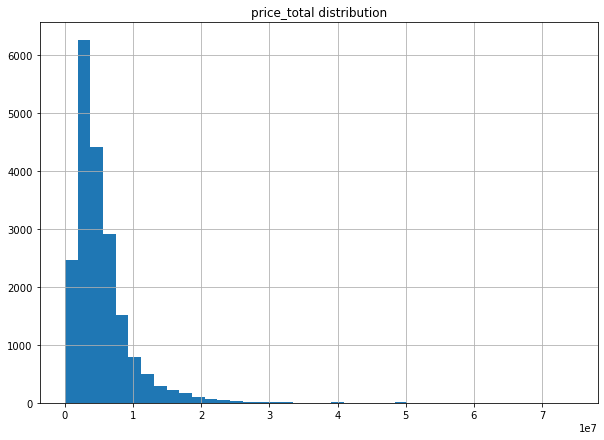

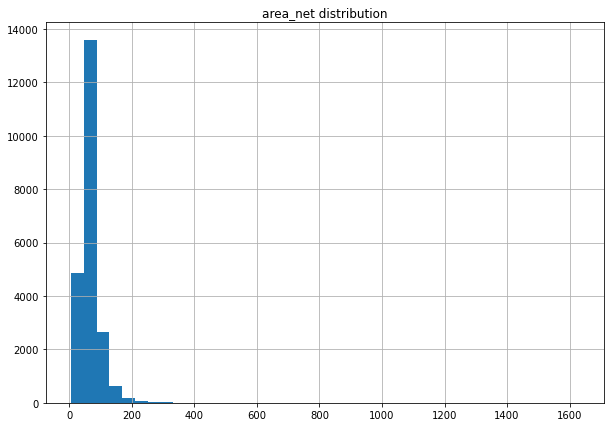

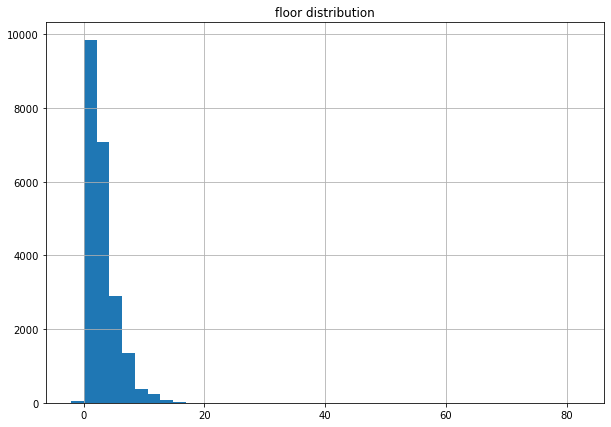

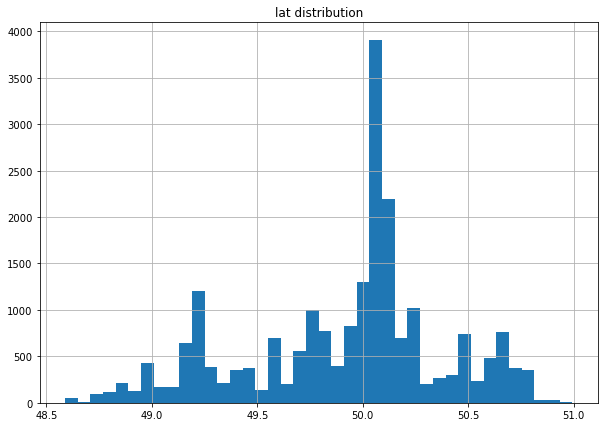

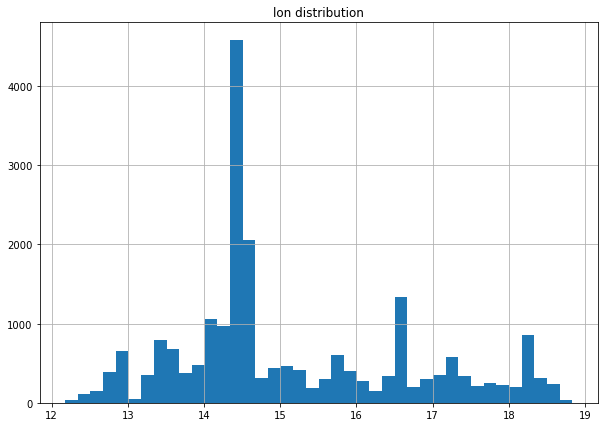

In [648]:
# Histograms:
columns = ["price_total", "area_net", "floor", "lat", "lon"]
for col in columns:
    plt.figure(figsize = (10,7))
    df[col].hist(bins=40)
    plt.title(col + " distribution")
    plt.show()
del columns

There is no a golden rule to detect outliers. We choose the basic automated approach for 'price_total' and 'area_net'.

We could use IQR:

In [649]:
"""
columns = ["price_total", "area_net", "floor"]
for col in columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df = df.loc[(df[col] > fence_low) & (df[col] < fence_high)]
del columns
"""

'\ncolumns = ["price_total", "area_net", "floor"]\nfor col in columns:\n    q1 = df[col].quantile(0.25)\n    q3 = df[col].quantile(0.75)\n    iqr = q3-q1 #Interquartile range\n    fence_low  = q1-1.5*iqr\n    fence_high = q3+1.5*iqr\n    df = df.loc[(df[col] > fence_low) & (df[col] < fence_high)]\ndel columns\n'

In [650]:
df.shape

(22026, 43)

But we decided to use 0.99 and 0.01 quantiles:

**We need to make sure to keep NaN values which will be tackled later.**

In [651]:
columns = ["price_total", "area_net"]
for col in columns:
    q_low = df[col].quantile(0.01)
    q_hi  = df[col].quantile(0.99)
    df = df[((df[col] < q_hi) & (df[col] > q_low)) | (df[col].isna())]
del columns

In [652]:
df.shape # Note that we have detected some outliers. 

(21120, 43)

In [653]:
# In addition, we will drop outliers of 'floor' column manually
# We drop rows which have 'floor' > 12 and < 0 as too high buildings could be considered outliers and buildings with negative floors could be consideredrare
df = df[((df["floor"] < 13) & (df["floor"] > 0)) | (df["floor"].isna())]

In [654]:
df.shape # Some outliers also detected in 'floor' column

(20979, 43)

#### Missing values:

<AxesSubplot:>

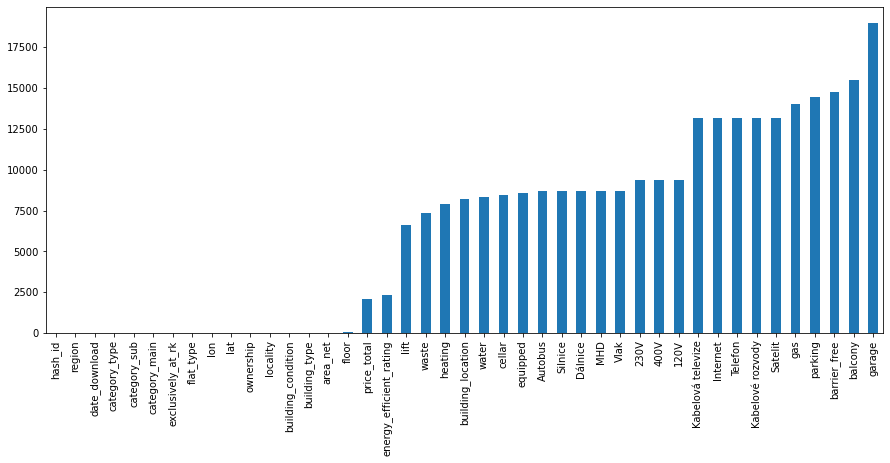

In [655]:
df.isna().sum().sort_values().plot.bar(figsize=(15, 6))

We can see that a lot of columns have a big portion of rows missing. So we will simply drop them.

In [656]:
# Drop columns with a lot of NaN
columns_to_drop = ['garage',
                   'balcony',
                   'barrier_free',
                   'parking',
                   'gas',
                   'Satelit',
                   'Kabelové rozvody',
                   'Telefon',
                   'Internet',
                   'Kabelová televize',
                   '120V',
                   '400V',
                   '230V',
                   'Vlak',
                   'MHD',
                   'Dálnice',
                   'Silnice',
                   'Autobus',
                   'equipped',
                   'cellar',
                   'water',
                   'building_location',
                   'heating',
                   'waste',
                   'lift',
                   ]

df.drop(columns_to_drop, axis=1, inplace= True)
del columns_to_drop

<AxesSubplot:>

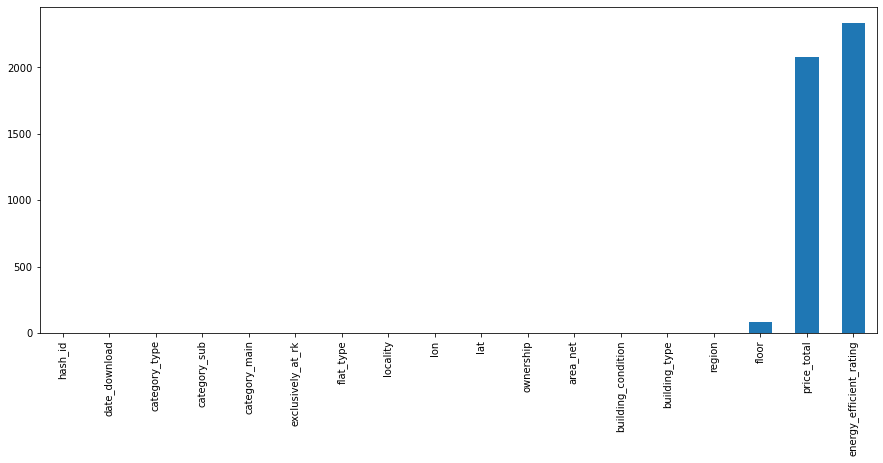

In [657]:
df.isna().sum().sort_values().plot.bar(figsize=(15, 6))

Next, we deal with the rest:

In [658]:
# 'energy_efficient_rating' -> fill with mode
df['energy_efficient_rating'].value_counts()

G    8731
B    4103
C    3576
D    1382
E     426
A     277
F     146
Name: energy_efficient_rating, dtype: int64

In [659]:
df['energy_efficient_rating'].fillna(df['energy_efficient_rating'].mode()[0], inplace = True)

In [660]:
# 'floor' -> fill with mode
# We convert it to object at first
df = df.astype({"floor": object})
df["floor"].value_counts()

2.0     4980
1.0     4496
3.0     3963
4.0     2873
5.0     1631
6.0     1074
7.0      754
8.0      529
9.0      226
10.0     150
11.0     124
12.0      93
Name: floor, dtype: int64

In [661]:
df["floor"].fillna(df["floor"].mode()[0], inplace = True)

In [662]:
df.shape

(20979, 18)

In [663]:
# 'price_toal' -> simply drop NaN rows
#df["price_total"].dropna(inplace=True)  -->  not working
df = df.dropna(subset=["price_total"], axis=0)

In [664]:
df.shape

(18902, 18)

<AxesSubplot:>

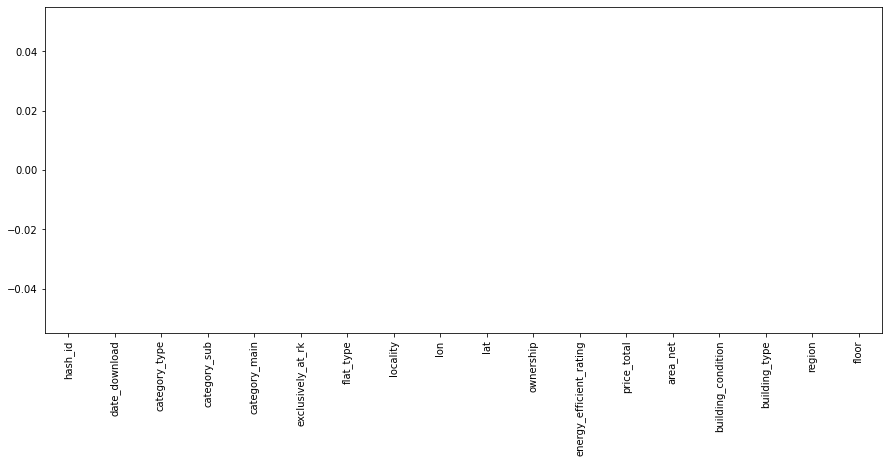

In [665]:
# Check
df.isna().sum().sort_values().plot.bar(figsize=(15, 6))

## Analyzing data

In [666]:
#Todo: comment on "exclusively_at_rk"

In [667]:
df.describe()

hash_id      area_net   price_total           lat           lon  \
count  1.890200e+04  18902.000000  1.890200e+04  18902.000000  18902.000000   
mean   2.143453e+09     66.420220  5.073797e+06     49.918775     15.150453   
std    1.235382e+09     24.616944  3.399289e+06      0.469761      1.539403   
min    6.383600e+04     25.000000  8.000000e+05     48.589103     12.177395   
25%    1.082028e+09     50.000000  2.690000e+06     49.664534     14.284074   
50%    2.134771e+09     63.000000  4.190000e+06     50.039193     14.519224   
75%    3.208614e+09     78.000000  6.500000e+06     50.152023     16.448302   
max    4.294956e+09    182.000000  2.101162e+07     50.993186     18.831846   

       exclusively_at_rk  category_main  category_sub  category_type  \
count       18902.000000        18902.0  18902.000000        18902.0   
mean            0.423765            1.0      5.355042            1.0   
std             0.494167            0.0      2.011899            0.0   
min             0.000000            1.0      2.000000            1.0   
25%             0.000000            1.0      4.000000            1.0   
50%             0.000000            1.0      5.000000            1.0   
75%             1.000000            1.0      7.000000            1.0   
max             1.000000            1.0     16.000000            1.0   

              floor  
count  18902.000000  
mean       3.242990  
std        2.154266  
min        1.000000  
25%        2.000000  
50%        3.000000  
75%        4.000000  
max       12.000000

We create a new variable "flat_size" from "area_net" column:

In [668]:
df["flat_size"] = pd.cut(df["area_net"], bins = [0,50,110,200], labels = ['small','medium','large'])

<AxesSubplot:>

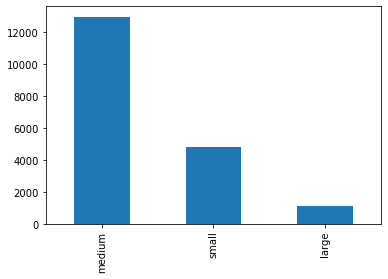

In [669]:
df["flat_size"].value_counts().plot(kind="bar") #normalize=True sort=True

Price

In [670]:
df["price_total"]

0        11500000.0
2         1780000.0
3         3900000.0
4         1599000.0
5         2833880.0
            ...    
22066      993600.0
22067     1999990.0
22068     8610000.0
22069     5546700.0
22070     3290000.0
Name: price_total, Length: 18902, dtype: float64

In [671]:
df["price_total"].describe()

count    1.890200e+04
mean     5.073797e+06
std      3.399289e+06
min      8.000000e+05
25%      2.690000e+06
50%      4.190000e+06
75%      6.500000e+06
max      2.101162e+07
Name: price_total, dtype: float64

Area

In [672]:
#df["price_total"].isnull().sum()

Locality

In [675]:
df.locality.value_counts()#.plot(kind="bar")

Praha 3 - Žižkov                      316
Most                                  311
Karlovy Vary                          235
Praha 5 - Smíchov                     207
Praha 5 - Stodůlky                    201
                                     ... 
Zvole, okres Šumperk                    1
Dřevohostice, okres Přerov              1
Vidnava, okres Jeseník                  1
Hradec nad Svitavou, okres Svitavy      1
Buřenice, okres Pelhřimov               1
Name: locality, Length: 1853, dtype: int64

#### Visualizations:

In [676]:
df[["region","flat_size"]].value_counts(sort=False) #normalize=True sort=True

region                flat_size
Jihomoravský kraj     small         453
                      medium       1140
                      large         130
Jihočeský kraj        small         195
                      medium        680
                      large          66
Karlovarský kraj      small         190
                      medium        784
                      large          98
Královéhradecký kraj  small         172
                      medium        479
                      large          30
Liberecký kraj        small         188
                      medium        473
                      large          33
Moravskoslezský kraj  small         368
                      medium       1191
                      large          45
Olomoucký kraj        small         267
                      medium        665
                      large          35
Pardubický kraj       small         121
                      medium        417
                      large          22
Plzeňský

<AxesSubplot:>

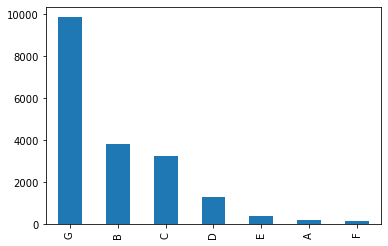

In [677]:
df["energy_efficient_rating"].value_counts().plot(kind="bar") #normalize=True sort=True

In [678]:
#median over groups: (region, energy_efficient_rating, area_net)
df.groupby(["region","flat_size"])["price_total"].median().sort_values(ascending = False)

region                flat_size
Praha                 large        15900000.0
Středočeský kraj      large         8999000.0
Jihomoravský kraj     large         8945000.0
Plzeňský kraj         large         8490450.0
Zlínský kraj          large         8490000.0
Jihočeský kraj        large         8097500.0
Praha                 medium        7999000.0
Královéhradecký kraj  large         7900000.0
Karlovarský kraj      large         7782012.0
Liberecký kraj        large         6900000.0
Pardubický kraj       large         6315855.0
Moravskoslezský kraj  large         6300000.0
Praha                 small         5349575.5
Jihomoravský kraj     medium        5300000.0
Ústecký kraj          large         5195000.0
Olomoucký kraj        large         4990000.0
Vysočina kraj         large         4990000.0
Středočeský kraj      medium        4917000.0
Královéhradecký kraj  medium        3999000.0
Jihomoravský kraj     small         3850000.0
Zlínský kraj          medium        3790000.0
Pl

Correlation:

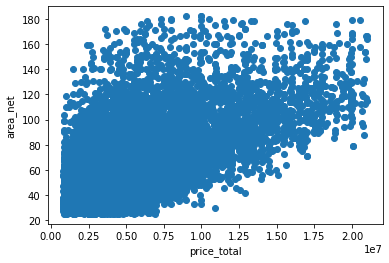

In [681]:
# Scatter plot:
plt.scatter(df['price_total'],df['area_net'])
plt.xlabel('price_total')
plt.ylabel('area_net')
plt.show()

In [682]:
df[["price_total", "area_net", "floor"]].corr()

price_total  area_net     floor
price_total     1.000000  0.542806  0.027346
area_net        0.542806  1.000000 -0.046061
floor           0.027346 -0.046061  1.000000